# Lesson 6: pets revisited

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
from fastai.vision import *

In [3]:
bs = 64

In [4]:
path = untar_data(URLs.PETS)/'images'

## Data augmentation

In [5]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4, p_affine=1., p_lighting=1.)

In [6]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/pomeranian_27.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/Maine_Coon_7.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/newfoundland_29.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/shiba_inu_135.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/Maine_Coon_192.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/beagle_39.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/Bengal_90.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/Bengal_50.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/British_Shorthair_64.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_113.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/pomeranian_43.jpg'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images/miniature_pinscher_2.jpg'

In [7]:
doc(get_transforms)

In [8]:
src = ImageItemList.from_folder(path).random_split_by_pct(0.2, seed=2)

In [9]:
src

ItemLists;

Train: ImageItemList (5912 items)
[Image (3, 500, 375), Image (3, 275, 183), Image (3, 375, 500), Image (3, 375, 500), Image (3, 333, 500)]...
Path: /home/jupyter/.fastai/data/oxford-iiit-pet/images;

Valid: ImageItemList (1478 items)
[Image (3, 333, 500), Image (3, 500, 414), Image (3, 500, 333), Image (3, 500, 406), Image (3, 375, 500)]...
Path: /home/jupyter/.fastai/data/oxford-iiit-pet/images;

Test: None

In [10]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [11]:
data = get_data(224, bs, 'zeros')

In [12]:
data.train_dl

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7fa0baf75f28>, device=device(type='cuda'), tfms=[functools.partial(<function _normalize_batch at 0x7fa070db3a60>, mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]), do_x=True, do_y=False)], collate_fn=<function data_collate at 0x7fa077f489d8>)

In [13]:
data.train_ds[8]

(Image (3, 224, 224), Category pomeranian)

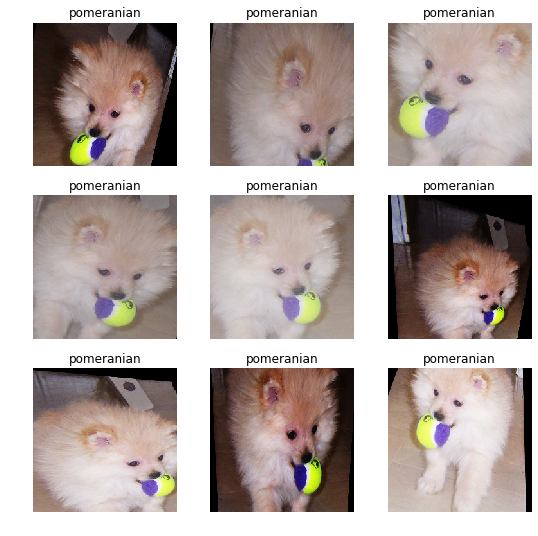

In [14]:
def _plot(i, j, ax):
    x, y = data.train_ds[8]
    x.show(ax, y=y)

def _plot_multi(func:Callable[[int, int, plt.Axes], None], r:int=1, c:int=1, figsize:Tuple=(12, 6)):
    axes = plt.subplots(r, c, figsize=figsize)[1] # plt.subplots() returns -> fig, axes
#     print(axes)
    for i in range(r):
        for j in range(c):
            func(i, j, axes[i,j])

_plot_multi(_plot, 3, 3, figsize=(9,9))

In [25]:
data = get_data(224, bs)

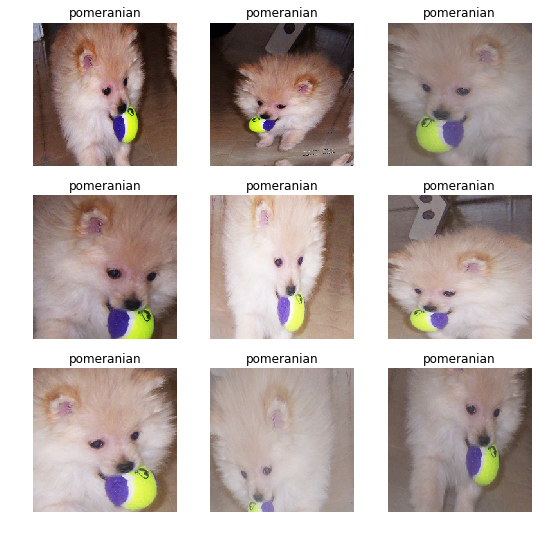

In [26]:
_plot_multi(_plot, 3, 3, figsize=(9,9))

## Train a model

In [32]:
gc.collect()
learn = create_cnn(data, models.resnet34, metrics=error_rate, bn_final=True)

In [33]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate
1,2.421679,1.122877,0.261840
2,1.430729,0.328883,0.082544
3,0.894530,0.260364,0.062923


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


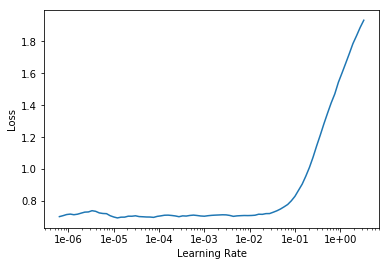

In [34]:
learn.lr_find()
learn.recorder.plot()

In [35]:
learn.unfreeze()

In [36]:
learn.fit_one_cycle(2, max_lr=slice(2e-6,1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate
1,0.699510,0.271825,0.055480
2,0.643955,0.268366,0.054804


In [37]:
data = get_data(352, bs)
learn.data = data

In [39]:
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.629948,0.240890,0.048038
2,0.569477,0.244938,0.048038


In [40]:
learn.save('352')

## Convolution kernel

In [41]:
data = get_data(size=352, bs=16)

In [42]:
learn = create_cnn(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

Category Maine_Coon

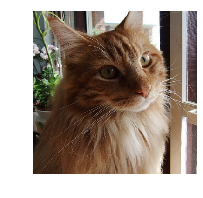

In [47]:
idx = 3
x, y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [66]:
# has 1 in its borders => will detect borders
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

In [67]:
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [68]:
k.shape

torch.Size([1, 3, 3, 3])

In [73]:
t = data.valid_ds[3][0].data; t.shape

torch.Size([3, 352, 352])

In [79]:
t

tensor([[[0.1200, 0.0577, 0.1422,  ..., 0.2737, 0.2876, 0.2118],
         [0.1693, 0.0468, 0.1224,  ..., 0.3356, 0.3186, 0.2967],
         [0.2236, 0.0466, 0.1176,  ..., 0.3507, 0.2479, 0.2116],
         ...,
         [0.2117, 0.2072, 0.2093,  ..., 0.5257, 0.6620, 0.8577],
         [0.2132, 0.2092, 0.2191,  ..., 0.5125, 0.6674, 0.8853],
         [0.2086, 0.2227, 0.2351,  ..., 0.5335, 0.7286, 0.8583]],

        [[0.1763, 0.1176, 0.2305,  ..., 0.2453, 0.2588, 0.1833],
         [0.2261, 0.1065, 0.1913,  ..., 0.3075, 0.2945, 0.2732],
         [0.2864, 0.1064, 0.1869,  ..., 0.3255, 0.2197, 0.1829],
         ...,
         [0.1314, 0.1339, 0.1426,  ..., 0.5034, 0.6662, 0.8733],
         [0.1269, 0.1359, 0.1524,  ..., 0.4878, 0.6691, 0.9049],
         [0.1317, 0.1485, 0.1621,  ..., 0.5078, 0.7289, 0.8748]],

        [[0.0842, 0.0156, 0.0608,  ..., 0.2956, 0.3108, 0.2328],
         [0.1556, 0.0185, 0.0483,  ..., 0.3745, 0.3472, 0.3162],
         [0.2224, 0.0180, 0.0436,  ..., 0.3850, 0.2750, 0.

In [81]:
t[None].shape

torch.Size([1, 3, 352, 352])

In [83]:
t[None]

tensor([[[[0.1200, 0.0577, 0.1422,  ..., 0.2737, 0.2876, 0.2118],
          [0.1693, 0.0468, 0.1224,  ..., 0.3356, 0.3186, 0.2967],
          [0.2236, 0.0466, 0.1176,  ..., 0.3507, 0.2479, 0.2116],
          ...,
          [0.2117, 0.2072, 0.2093,  ..., 0.5257, 0.6620, 0.8577],
          [0.2132, 0.2092, 0.2191,  ..., 0.5125, 0.6674, 0.8853],
          [0.2086, 0.2227, 0.2351,  ..., 0.5335, 0.7286, 0.8583]],

         [[0.1763, 0.1176, 0.2305,  ..., 0.2453, 0.2588, 0.1833],
          [0.2261, 0.1065, 0.1913,  ..., 0.3075, 0.2945, 0.2732],
          [0.2864, 0.1064, 0.1869,  ..., 0.3255, 0.2197, 0.1829],
          ...,
          [0.1314, 0.1339, 0.1426,  ..., 0.5034, 0.6662, 0.8733],
          [0.1269, 0.1359, 0.1524,  ..., 0.4878, 0.6691, 0.9049],
          [0.1317, 0.1485, 0.1621,  ..., 0.5078, 0.7289, 0.8748]],

         [[0.0842, 0.0156, 0.0608,  ..., 0.2956, 0.3108, 0.2328],
          [0.1556, 0.0185, 0.0483,  ..., 0.3745, 0.3472, 0.3162],
          [0.2224, 0.0180, 0.0436,  ..., 0

In [84]:
edge = F.conv2d(t[None], k)

In [92]:
edge[0].shape

torch.Size([1, 350, 350])

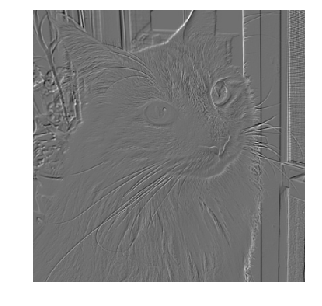

In [95]:
show_image(edge[0], figsize=(5,5))

In [96]:
data.c

37

In [97]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [100]:
learn.summary()

'======================================================================\nLayer (type)         Output Shape         Param #    Trainable \n======================================================================\nConv2d               [16, 64, 176, 176]   9408       False     \n______________________________________________________________________\nBatchNorm2d          [16, 64, 176, 176]   128        True      \n______________________________________________________________________\nReLU                 [16, 64, 176, 176]   0          False     \n______________________________________________________________________\nMaxPool2d            [16, 64, 88, 88]     0          False     \n______________________________________________________________________\nConv2d               [16, 64, 88, 88]     36864      False     \n______________________________________________________________________\nBatchNorm2d          [16, 64, 88, 88]     128        True      \n________________________________________

## Heatmap

In [106]:
m = learn.model.eval(); m

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [103]:
from fastai.callbacks.hooks import *

In [105]:
m[0] # convolutional part of the model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, ker

In [102]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [107]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a:
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0, int(cat)].backward()
    return hook_a, hook_g

In [108]:
hook_a, hook_g = hooked_backward()

In [109]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

In [110]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

In [111]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

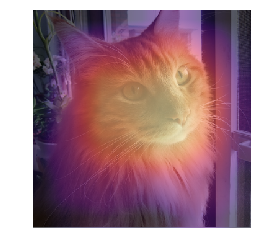

In [112]:
show_heatmap(avg_acts)

## Grad-CAM

Paper: [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

In [113]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([512, 11, 11]), torch.Size([512]))

In [114]:
mult = (acts*grad_chan[...,None,None]).mean(0)

In [123]:
fn = path/'../bulldog_maine.png'

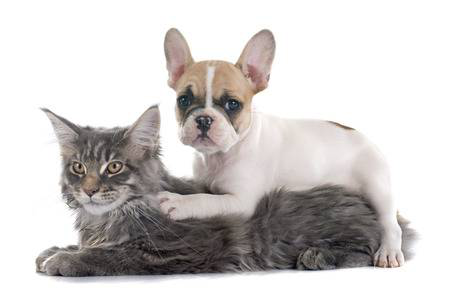

In [124]:
x = open_image(fn); x

In [125]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [126]:
hook_a,hook_g = hooked_backward()

In [127]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

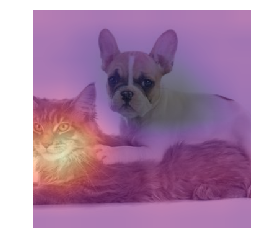

In [128]:
show_heatmap(mult)

In [ ]:
data.classes[0]

'american_bulldog'

In [130]:
hook_a,hook_g = hooked_backward(0)

In [131]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

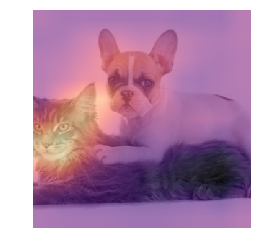

In [132]:
show_heatmap(mult)

## fin